In [2]:
import os
import re
import pandas as pd
import numpy as np
import gc

import tensorflow as tf
from tensorflow.keras import optimizers, callbacks,models,layers
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

## Uncomment those lines if you have a GPU

In [3]:
# Uncomment those lines if you have gpu.
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2022-02-02 23:47:47.114164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 23:47:47.136776: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 23:47:47.136931: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


**Function to Create Dataset**

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
damage_path = '../data/relevance'
images_path = '../data/ASONAM17_Damage_Image_Dataset/'
IMG_SIZE = 224
data_augmentation_layer = tf.keras.Sequential([
                                  layers.RandomFlip("horizontal_and_vertical"),
                                  layers.RandomRotation(0.2),
                                  layers.RandomCrop(IMG_SIZE,IMG_SIZE),
                                  layers.RandomContrast(factor=0.8)
])

    
def create_dataset(damage_path,event,is_augment=False,batch_size=32,buffer_size=100):

    label_path = os.path.join(damage_path,event)
    
    img_gen = ImageDataGenerator(rescale=1/255.0,)
        
    train_df = pd.read_csv(os.path.join(label_path,'train.csv'),header=None)
    train_df.columns = ['path','label']

    train_gen = img_gen.flow_from_dataframe(dataframe = train_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',          
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))



    valid_df = pd.read_csv(os.path.join(label_path,'dev.csv'),header=None)
    valid_df.columns = ['path','label']

    valid_gen = img_gen.flow_from_dataframe(dataframe = valid_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',         
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE))
    
    test_df = pd.read_csv(os.path.join(label_path,'test.csv'),header=None)
    test_df.columns = ['path','label']

    test_gen = img_gen.flow_from_dataframe(dataframe = test_df,
                                directory=images_path,
                                x_col='path',
                                y_col='label',
                                class_mode='raw',         
                                batch_size=batch_size,
                                target_size= (IMG_SIZE,IMG_SIZE)) 
      
    # Now we're converting our ImageDataGenerator to Dataset

    train_dataset = tf.data.Dataset.from_generator(
            lambda: train_gen ,  # Our generator 
            output_types = (tf.float32 , tf.float32) , # How we're expecting our output dtype
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ]) # How we're expecting our output shape
        )

    valid_dataset = tf.data.Dataset.from_generator(
            lambda: valid_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )
    
    test_dataset = tf.data.Dataset.from_generator(
            lambda: test_gen , 
            output_types = (tf.float32 , tf.float32), 
            output_shapes = ([None , IMG_SIZE , IMG_SIZE , 3] , [None , ])
        )

    if is_augment:
        train_dataset = train_dataset.map(lambda x,y: (data_augmentation_layer(x,training=True),y),
                                num_parallel_calls=tf.data.AUTOTUNE)
            
    print(f"steps_per_epochs: {len(train_df)// batch_size}")
    print(f"validations_steps: {len(valid_df)// batch_size}")
        
        
    steps_per_epoch = len(train_df)// batch_size
    validation_steps = len(valid_df)// batch_size


    train_dataset = train_dataset.prefetch(buffer_size=10)
    valid_dataset = valid_dataset.prefetch(buffer_size=10)

    return train_dataset,valid_dataset,test_dataset,steps_per_epoch,validation_steps

2022-02-02 23:47:50.902295: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-02 23:47:50.902965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 23:47:50.903164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-02 23:47:50.903292: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# Function to copy the images to relevant directoryes for experiment

In [5]:
def create_combined_dataset(data_directory, project='relevance'):
    main_path = os.path.join(data_directory, 'relevance')
    #os.chdir(main_path)
    # Create directory for the data
    output_direct = 'combined_data'
    try:
        os.mkdir(os.path.join(main_path, output_direct))
    except FileExistsError:
        print(f"{os.path.join(main_path, output_direct)} is already there")
        
    pd_dev = pd.DataFrame()
    pd_train = pd.DataFrame()
    pd_test = pd.DataFrame()
    
    for (this_direct, sub_dir, file_here) in os.walk(main_path):
        if this_direct is not output_direct:
            for file in file_here:
                if file.endswith('.csv'):
                    file_path = os.path.join(this_direct, file)
                    temp_df = pd.read_csv(file_path)
                    temp_df.columns = ['path','label']
                    if file.startswith('dev.'):                 
                        if pd_dev.empty:
                            pd_dev = temp_df
                        else:
                            pd_dev = pd_dev.append(temp_df, ignore_index=True)
                    elif file.startswith('train.'):
                        if pd_train.empty: 
                            pd_train = temp_df
                        else:
                            pd_train = pd_train.append(temp_df, ignore_index=True)
                    elif file.startswith('test.'):
                        if pd_test.empty:
                            pd_test = temp_df
                        else:
                            pd_test = pd_test.append(temp_df, ignore_index=True)
                    else:
                        pass

    dev_filename = os.path.join(main_path, f"{output_direct}/dev.csv")
    if not os.access(dev_filename, os.F_OK):
        pd_dev.to_csv(dev_filename, index=False, header=False)
        print(f'{dev_filename} created')
    else:
        print(f'{dev_filename} already created')
        
    train_filename = os.path.join(main_path, f"{output_direct}/train.csv")
    if not os.access(train_filename, os.F_OK):
        pd_train.to_csv(train_filename, index=False, header=False)
        print(f'{train_filename} created')
    else:
        print(f'{train_filename} already created')

    test_filename = os.path.join(main_path, f"{output_direct}/test.csv")
    if not os.access(test_filename, os.F_OK):
        pd_test.to_csv(test_filename, index=False, header=False)
        print(f'{test_filename} created')
    else:
        print(f'{test_filename} already created')

# Actual creation of the dataset

In [6]:
data_directory = "../data"
create_combined_dataset(data_directory, 'relevance')

train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'combined_data',
                                    is_augment=False,batch_size=32,buffer_size=100)

../data/relevance/combined_data is already there
../data/relevance/combined_data/dev.csv already created
../data/relevance/combined_data/train.csv already created
../data/relevance/combined_data/test.csv already created
Found 15487 validated image filenames.
Found 5161 validated image filenames.
Found 5157 validated image filenames.
steps_per_epochs: 483
validations_steps: 161


# Function to show curve

In [7]:
def subplot_learning_curve_d(history):
    #plt.clf()
    plt.figure(figsize=(10,5))
    for i,metric in enumerate(['acc','loss']):
        plt.subplot(1,2,i+1)
        plt.plot(history.history[metric])
        plt.plot(history.history['val_' + metric])
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend((metric, 'val_' + metric))
        plt.title(": Learning curve " + metric + " vs " + 'val_' + metric)
    plt.show()

In [10]:
def vgg16_feature_extract(damage_path, img_size=224, batch_size=32, buffer_size=100, n_epochs=20, regularization=False, augmentation=False):
    
    conv_base = VGG16(weights='imagenet',
                      include_top = False,
                      input_shape=(img_size,img_size,3))

    # Freezing the base model
    conv_base.trainable = False
    vgg16model = models.Sequential()
    vgg16model.add(conv_base)
    if regularization:
        vgg16model.add(layers.GlobalAveragePooling2D())
        vgg16model.add(layers.Dropout(0.2))       
    vgg16model.add(layers.Flatten())
    vgg16model.add(layers.Dense(256, activation='relu'))
    vgg16model.add(layers.Dense(1, activation='sigmoid'))
    
    print(vgg16model.summary())
    
    vgg16model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])

    train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'combined_data',
                                        is_augment=augmentation,batch_size=batch_size,buffer_size=buffer_size)

    history = vgg16model.fit(train_ds,
                            initial_epoch=n_epochs,
                            epochs=2*n_epochs,
                            steps_per_epoch = steps_per_epoch,
                            validation_data=valid_ds,
                            validation_steps = validation_steps)
    
    return history


# Run VGG16 Feature Extraction Model with Regularization

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                      

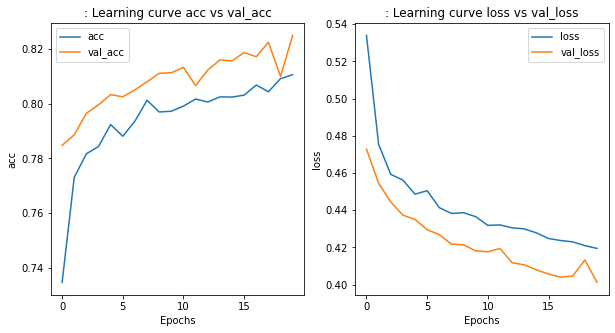

In [11]:
history = vgg16_feature_extract(damage_path, 
                      img_size=224, 
                      batch_size=32, 
                      buffer_size=100, 
                      n_epochs=20, 
                      regularization=True, 
                      augmentation=False)

subplot_learning_curve_d(history)

# Run Feature extraction without regularization

In [ ]:
history = vgg16_feature_extract(damage_path, 
                      img_size=224, 
                      batch_size=32, 
                      buffer_size=100, 
                      n_epochs=20, 
                      regularization=False, 
                      augmentation=False)

subplot_learning_curve_d(history)

# VGG16 finetune

In [15]:
def vgg16_finetuned(damage_path, img_size=224, batch_size=32, buffer_size=100, n_epochs=20, regularization=False, augmentation=False):
    
    conv_base = VGG16(weights='imagenet',
                      include_top = False,
                      input_shape=(img_size,img_size,3))

    # Freezing the base model
    conv_base.trainable = True
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable =True
        else:
            layer.trainable = False
    print(conv_base.summary())
    vgg16model = models.Sequential()
    vgg16model.add(conv_base)
    if regularization:
        vgg16model.add(layers.GlobalAveragePooling2D())
        vgg16model.add(layers.Dropout(0.2))       
    vgg16model.add(layers.Flatten())
    vgg16model.add(layers.Dense(256, activation='relu'))
    vgg16model.add(layers.Dense(1, activation='sigmoid'))
    
    print(vgg16model.summary())
    
    vgg16model.compilehttp://localhost:8888/notebooks/ProjectAI/disaster-hackaton/disaster-damage-assessment-ml/notebooks/NewTrial.ipynb#Run-VGG16-finetune-no-regularization(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                   loss = 'binary_crossentropy',
                   metrics = ['acc'])

    train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'combined_data',
                                        is_augment=augmentation,batch_size=batch_size,buffer_size=buffer_size)

    history = vgg16model.fit(train_ds,
                            initial_epoch=n_epochs,
                            epochs=2*n_epochs,
                            steps_per_epoch = steps_per_epoch,
                            validation_data=valid_ds,
                            validation_steps = validation_steps)
    
    return history

# Run VGG16 finetune no regularization

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

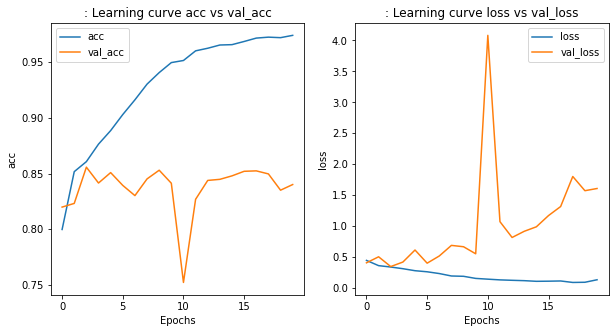

In [16]:
history = vgg16_finetuned(damage_path, 
                      img_size=224, 
                      batch_size=32, 
                      buffer_size=100, 
                      n_epochs=20, 
                      regularization=False, 
                      augmentation=False)

subplot_learning_curve_d(history)

**Run VGG16 finetune with regularization**

In [ ]:
history = vgg16_finetuned(damage_path, 
                      img_size=224, 
                      batch_size=32, 
                      buffer_size=100, 
                      n_epochs=20, 
                      regularization=True, 
                      augmentation=False)

subplot_learning_curve_d(history)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
def relevance_model(image_size):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPool2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    
    model.compile(loss='binary_crossentropy',
                 optimizer=optimizers.RMSprop(learning_rate=1e-4),
                 metrics=['acc'])
    model.summary()
    return model

In [ ]:
generic_model = relevance_model(IMG_SIZE)

In [ ]:
train_ds, valid_ds,test_ds,steps_per_epoch,validation_steps, = create_dataset(damage_path,'combined_data',
                                    is_augment=False,batch_size=32,buffer_size=100)

n_epochs=20
print("Training..................")
history = generic_model.fit(train_ds,
                epochs=n_epochs,
                steps_per_epoch = steps_per_epoch,
                validation_data=valid_ds,
                validation_steps = validation_steps)